This data loads the data sets, applies quality cuts, and saves them together as galaxy objects for use in other notebooks. Afterward, I make some plots to characterize the data set.

NOTE that eventually this notebook should completely replace the readme in the data folder. Also, I may need to move the script to make the catalog for BPZ into this notebook...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import pickle

from modules import Galaxy, get_bandpass_dict, get_eff_wavelen

In [2]:
# plotting style
%config InlineBackend.figure_format = 'retina'
plt.style.use('paper.mplstyle')

## **Load the Bandpasses**

In [3]:
bandpass_dict = get_bandpass_dict()

## **Loading and trimming the data set**

Load the data sets, and apply quality cuts. I also throw out any galaxy not observed in the i band, because I will use this for normalization, and the magnitude prior. Might do something more sophisticated later.

### *Zhou et al. catalog*

This catalog consists of CFHTLS/Subaru photometry paired with DEEP2/3 and HST spec-z's. The catalog is described in [Zhou et al.](https://doi.org/10.1093/mnras/stz1866), and the data can be downloaded [here](http://d-scholarship.pitt.edu/36064/).
Only the most secure redshifts are kept (z quality $\geq$ 3 for DEEP2/3; z quality $=$ 1 for HST), and all [SExtractor flags](https://sextractor.readthedocs.io/en/latest/Flagging.html) are required to be < 4. We throw out saturated, masked or blended objects and objects identified as stars by CFHTLS by requiring the CFHTLS flag = 1. We also throw out any objects without "class" = GALAXY.

#### Deep2/3 catalog

In [4]:
cat = Table.read("data/DEEP2_uniq_Terapix_Subaru_v1.fits")
print("The Deep2/3 catalog contains",len(cat),"objects")

# quality cuts on data
uflag  = cat['u(sexflag)']
gflag  = cat['g(sexflag)']
rflag  = cat['r(sexflag)']
i2flag = cat['i2(sexflag)']
iflag  = cat['i(sexflag)']
zflag  = cat['z(sexflag)']
yflag  = cat['y(sexflag)']
cflag  = cat['flag_cfhtls']
zqual  = cat['zquality']
Class  = cat['class']

S = 4 # SExtractor flag

idx = np.where( (  uflag < S ) &
                (  gflag < S ) &
                (  rflag < S ) &
                ( i2flag < S ) &
                (  iflag < S ) &
                (  zflag < S ) &
                (  yflag < S ) &
                ( cflag == 0 ) &
                ( zqual >= 3 ) &
                ( Class == 'GALAXY' ) )

cat = cat[idx]
print("After quality cuts, we have",len(cat),"objects")

# get the data
redshift  = cat['zhelio']

u  = cat['u_apercor']
g  = cat['g_apercor']
r  = cat['r_apercor']
i2 = cat['i2_apercor']
i  = cat['i_apercor']
z  = cat['z_apercor']
y  = cat['y_apercor']

uerr  = np.sqrt( cat['uerr_aper']**2  +  cat['uerr_apercor']**2 )
gerr  = np.sqrt( cat['gerr_aper']**2  +  cat['gerr_apercor']**2 )
rerr  = np.sqrt( cat['rerr_aper']**2  +  cat['rerr_apercor']**2 )
i2err = np.sqrt( cat['i2err_aper']**2 + cat['i2err_apercor']**2 )
ierr  = np.sqrt( cat['ierr_aper']**2  +  cat['ierr_apercor']**2 )
zerr  = np.sqrt( cat['zerr_aper']**2  +  cat['zerr_apercor']**2 )
yerr  = np.sqrt( cat['yerr_aper']**2  +  cat['yerr_apercor']**2 )

# save the data
deep_galaxies = []
for j in range(len(redshift)):
    
    mags = np.array([u[j],g[j],r[j],i2[j],i[j],z[j],y[j]])
    errs = np.array([uerr[j],gerr[j],rerr[j],i2err[j],ierr[j],zerr[j],yerr[j]])
    filters = np.array(['u','g','r','i2','i','z','y'])
    idx = np.where( ( mags > -99 ) & ( mags < 99 ) )
    
    # if the galaxy was observed in zero bands, skip it
    if idx[0].size == 0:
        continue

    galaxy = Galaxy()
    galaxy.wavelen = get_eff_wavelen(bandpass_dict,filters[idx])
    galaxy.mags = mags[idx]
    galaxy.mag_err = errs[idx]
    galaxy.magToflux()
    galaxy.filters = filters[idx]
    galaxy.redshift = redshift[j]
    galaxy.source = 'DEEP2/3'
    
    if 'i' not in galaxy.filters:
        continue
    
    deep_galaxies.append(galaxy)
    
print("After removing objects with no photometry at all, or no photometry in the i band, we have",len(deep_galaxies),"objects")

The Deep2/3 catalog contains 23822 objects
After quality cuts, we have 14172 objects
After removing objects with no photometry at all, or no photometry in the i band, we have 14029 objects


#### HST catalog

In [5]:
cat = Table.read("data/3D-HST_Terapix_Subaru_v1.fits")
print("The HST catalog contains",len(cat),"objects")

# remove objects that are also in DEEP2/3 catalog
deep2N = cat['objno_deep2']
idx = np.where( deep2N == -99 )
cat = cat[idx]
print("There are",len(cat),"objects that aren't in Deep2/3")

# quality cuts on data
uflag  = cat['u(sexflag)']
gflag  = cat['g(sexflag)']
rflag  = cat['r(sexflag)']
i2flag = cat['i2(sexflag)']
iflag  = cat['i(sexflag)']
zflag  = cat['z(sexflag)']
yflag  = cat['y(sexflag)']
cflag  = cat['flag_cfhtls']
zqual  = cat['use_zgrism1']

S = 4 # SExtractor flag

idx = np.where( (  uflag < S ) &
                (  gflag < S ) &
                (  rflag < S ) &
                ( i2flag < S ) &
                (  iflag < S ) &
                (  zflag < S ) &
                (  yflag < S ) &
                ( cflag == 0 ) &
                ( zqual == 1 ) )

cat = cat[idx]
print("After quality cuts, we have",len(cat),"objects")

# get the data
redshift  = cat['z_max_grism']

u  = cat['u_apercor']
g  = cat['g_apercor']
r  = cat['r_apercor']
i2 = cat['i2_apercor']
i  = cat['i_apercor']
z  = cat['z_apercor']
y  = cat['y_apercor']

uerr  = np.sqrt( cat['uerr_aper']**2  +  cat['uerr_apercor']**2 )
gerr  = np.sqrt( cat['gerr_aper']**2  +  cat['gerr_apercor']**2 )
rerr  = np.sqrt( cat['rerr_aper']**2  +  cat['rerr_apercor']**2 )
i2err = np.sqrt( cat['i2err_aper']**2 + cat['i2err_apercor']**2 )
ierr  = np.sqrt( cat['ierr_aper']**2  +  cat['ierr_apercor']**2 )
zerr  = np.sqrt( cat['zerr_aper']**2  +  cat['zerr_apercor']**2 )
yerr  = np.sqrt( cat['yerr_aper']**2  +  cat['yerr_apercor']**2 )

# save the data
hst_galaxies = []
for j in range(len(redshift)):
    
    mags = np.array([u[j],g[j],r[j],i2[j],i[j],z[j],y[j]])
    errs = np.array([uerr[j],gerr[j],rerr[j],i2err[j],ierr[j],zerr[j],yerr[j]])
    filters = np.array(['u','g','r','i2','i','z','y'])
    idx = np.where( ( mags > -99 ) & ( mags < 99 ) )
    
    # if the galaxy was observed in zero bands, skip it
    if idx[0].size == 0:
        continue
    
    galaxy = Galaxy()
    galaxy.wavelen = get_eff_wavelen(bandpass_dict,filters[idx])
    galaxy.mags = mags[idx]
    galaxy.mag_err = errs[idx]
    galaxy.magToflux()
    galaxy.filters = filters[idx]
    galaxy.redshift = redshift[j]
    galaxy.source = '3D-HST'
    
    if 'i' not in galaxy.filters:
        continue
        
    hst_galaxies.append(galaxy)

print("After removing objects with no photometry at all, or no photometry in the i band, we have",len(hst_galaxies),"objects")

The HST catalog contains 14462 objects
There are 12546 objects that aren't in Deep2/3
After quality cuts, we have 1706 objects
After removing objects with no photometry at all, or no photometry in the i band, we have 1621 objects


### *COSMOS catalog*

Add more details here

In [6]:
cat = Table.read('data/zcosmost_bright20k.csv',format='csv')
print("The zCOSMOS catalog contains",len(cat),"objects")

idx = np.where( cat['zpec'] > 0 )
cat = cat[idx]
print(len(cat),"objects have redshift > 0")

idx = np.where( cat['id_photzi25'] != 9999999 )
cat = cat[idx]
print("Of these, we have photometry for",len(cat))

# quality cuts on data
idx = np.where(( cat['flag_maskb_photzi25'] == 0 ) &
               ( cat['flag_maskv_photzi25'] == 0 ) &
               ( cat['flag_maski_photzi25'] == 0 ) &
               ( cat['flag_maskz_photzi25'] == 0 ) &
               ( cat['flag_maskd_photzi25'] == 0 ) )

cat = cat[idx]
print("After quality cuts, we have",len(cat),"objects")

# get the data
redshift = cat['zpec']

FUV = cat['fuv_photzi25']
NUV = cat['nuv_photzi25']
u   = cat['u_photzi25']
B   = cat['b_photzi25']
gp  = cat['g_photzi25']
V   = cat['v_photzi25']
rp  = cat['r_photzi25']
i   = cat['ic_photzi25']
ip  = cat['i_photzi25']
zp  = cat['z_photzi25']
J   = cat['j_photzi25']
K   = cat['k_photzi25']

FUVerr = cat['efuv_photzi25']
NUVerr = cat['enuv_photzi25']
uerr   = cat['eu_photzi25']
Berr   = cat['eb_photzi25']
gperr  = cat['eg_photzi25']
Verr   = cat['ev_photzi25']
rperr  = cat['er_photzi25']
ierr   = cat['eic_photzi25']
iperr  = cat['ei_photzi25']
zperr  = cat['ez_photzi25']
Jerr   = cat['ej_photzi25']
Kerr   = cat['ek_photzi25']

# save the data
cosmos_galaxies = []
for j in range(len(redshift)):
    
    mags = np.array([FUV[j],NUV[j],u[j],B[j],gp[j],V[j],rp[j],i[j],ip[j],zp[j],J[j],K[j]])
    errs = np.array([FUVerr[j],NUVerr[j],uerr[j],Berr[j],gperr[j],Verr[j],rperr[j],ierr[j],iperr[j],zperr[j],Jerr[j],Kerr[j]])
    filters = np.array(['FUV','NUV','u','B','g+','V','r+','i','i+','z+','J','K'])
    idx = np.where( ( mags > -99 ) & ( mags < 99 ) )
    
    galaxy = Galaxy()
    galaxy.wavelen = get_eff_wavelen(bandpass_dict,filters[idx])
    galaxy.mags = mags[idx]
    galaxy.mag_err = np.fabs(errs[idx])
    galaxy.magToflux()
    galaxy.filters = filters[idx]
    galaxy.redshift = redshift[j]
    galaxy.source = 'zCOSMOS'
    
    if 'i' not in galaxy.filters:
        continue
        
    cosmos_galaxies.append(galaxy)

print("After removing objects with no photometry at all, or no photometry in the i band, we have",len(cosmos_galaxies),"objects")

The zCOSMOS catalog contains 17358 objects
16650 objects have redshift > 0
Of these, we have photometry for 16480
After quality cuts, we have 14311 objects
After removing objects with no photometry at all, or no photometry in the i band, we have 14294 objects


## **Save the final galaxy catalog**

In [7]:
# collect all the galaxies into one flat list
galaxies = [deep_galaxies,hst_galaxies,cosmos_galaxies]
galaxies = [galaxy for sublist in galaxies for galaxy in sublist]

print("The final catalog has",len(galaxies),"galaxies")
redshifts = [galaxy.redshift for galaxy in galaxies]
print("The redshift range is {0:.4f} to {1:.2f}".format(min(redshifts),max(redshifts)))

filename = 'data/galaxy_catalog.pkl'
with open(filename, 'wb') as output:
    pickle.dump(galaxies, output)
print("\nSaving '"+filename+"'")

The final catalog has 29944 galaxies
The redshift range is 0.0004 to 3.32

Saving 'data/galaxy_catalog.pkl'


## **Plots to characterize the data set**

Magnitudes

CPU times: user 9min 24s, sys: 752 ms, total: 9min 25s
Wall time: 9min 25s


Text(0, 0.5, 'Magnitude')

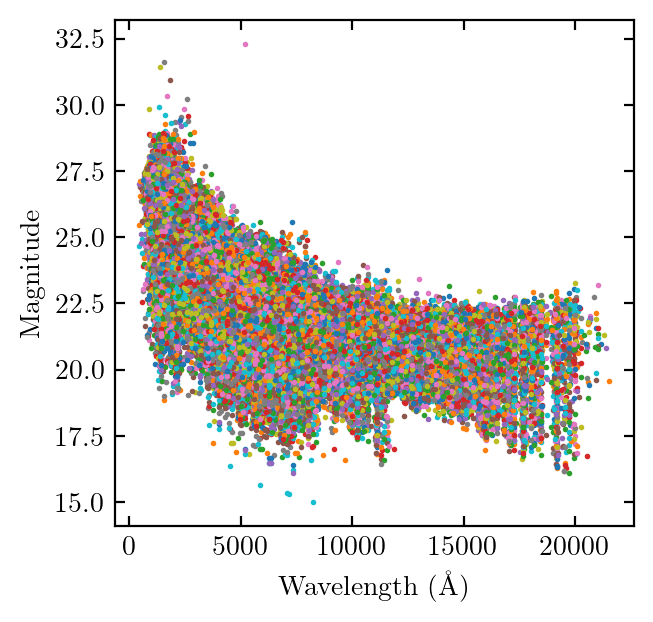

In [10]:
%%time
for galaxy in galaxies:
    plt.scatter(galaxy.wavelen/(1+galaxy.redshift),galaxy.mags,s=1)

plt.xlabel("Wavelength ($\mathrm{\AA}$)")
plt.ylabel("Magnitude")
plt.show()

Redshift histogram per catalog

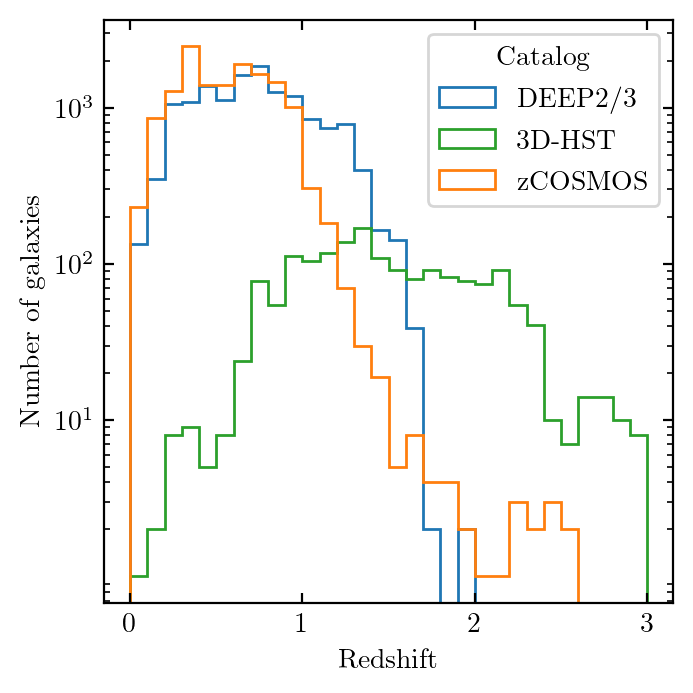

In [39]:
fig,ax = plt.subplots(constrained_layout=True)

deep_redshifts = []
hst_redshifts = []
cosmos_redshifts = []
for galaxy in galaxies:
    if galaxy.source == 'DEEP2/3':
        deep_redshifts.append(galaxy.redshift)
    elif galaxy.source == '3D-HST':
        hst_redshifts.append(galaxy.redshift)
    elif galaxy.source == 'zCOSMOS':
        cosmos_redshifts.append(galaxy.redshift)
        
ax.hist(deep_redshifts,range=(0,3),bins=30,histtype='step',label='DEEP2/3',color='C0')
ax.hist(hst_redshifts,range=(0,3),bins=30,histtype='step',label='3D-HST',color='C2')
ax.hist(cosmos_redshifts,range=(0,3),bins=30,histtype='step',label='zCOSMOS',color='C1')

ax.legend(title="Catalog")

ax.set_xlabel('Redshift')
ax.set_ylabel('Number of galaxies')
ax.set_yscale('log')
ax.set_yticks([10,100,1000])
plt.show()

Redshift histogram per i-band magnitude

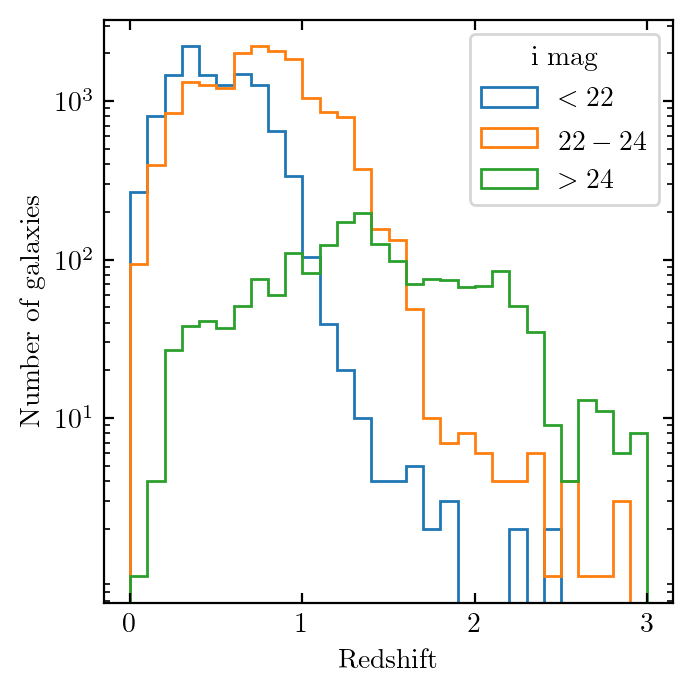

In [43]:
fig,ax = plt.subplots(constrained_layout=True)

redshifts = np.array([])
imags = np.array([])
for galaxy in galaxies:
    if 'i' in galaxy.filters:
        redshifts = np.append(redshifts,galaxy.redshift)
        idx = np.where(galaxy.filters == 'i')
        imags = np.append(imags,galaxy.mags[idx])
        
idx = np.where( imags <= 22 )
ax.hist(redshifts[idx],range=(0,3),bins=30,histtype='step',label='$<22$')
idx = np.where( ( imags > 22 ) & ( imags <= 24 ) )
ax.hist(redshifts[idx],range=(0,3),bins=30,histtype='step',label='$22-24$')
idx = np.where( imags > 24 )
ax.hist(redshifts[idx],range=(0,3),bins=30,histtype='step',label='$>24$')

ax.legend(title='i mag')

ax.set_xlabel('Redshift')
ax.set_ylabel('Number of galaxies')
ax.set_yscale('log')
ax.set_yticks([10,100,1000])

plt.show()